In [1]:
# Import necessary libraries
import pandas as pd
import datetime 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:

df = pd.read_csv('20_Companies_cleaner.csv', index_col='Unnamed: 0')
df['Date'] = df["Date"].apply(lambda x:
                             datetime.datetime.strptime(x, "%Y-%m-%d"))
#Obtain data for a specific company in the groupings
companies = df.groupby('Code')
company_data = companies.get_group('EQTY')
company_data = company_data[['Date', 'Day Price']]
company_data.set_index('Date', drop=True, inplace=True)

In [3]:
#Scale down the values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_x = scaler.fit_transform(company_data)
scaled_company_data = pd.DataFrame(columns=company_data.columns,
                         data=scaled_x,
                         index=company_data.index)
scaled_company_data

,Day Price
Date,
2022-01-03,0.934783
2022-01-04,0.978261
2022-01-05,0.956522
2022-01-06,0.956522
2022-01-07,0.956522
...,...
2022-05-25,0.000000
2022-05-26,0.078261
2022-05-27,0.173913


In [4]:
#Define the splitting function for making timestamps of size n
def lstm_split(data, n_steps):
    x,y=[],[]
    for i in range(len(data)-n_steps+1):
        x.append(data[i:i+n_steps])
        y.append(data[i+n_steps-1])
    return np.array(x), np.array(y)

In [5]:
#split the data into train and test
x1, y1 = lstm_split(scaled_company_data['Day Price'].values, 10)
split_ratio = 0.8
split_index = int(split_ratio * len(x1))
x_train, x_test = x1[:split_index], x1[split_index:]
y_train, y_test = y1[:split_index], y1[split_index:]

In [6]:
#Train the model
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn import metrics
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(10,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

2023-12-14 21:59:42.677728: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 21:59:42.732236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 21:59:42.732284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 21:59:42.733795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 21:59:42.741626: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 21:59:43.963675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

Epoch 1/100
3/3 [==============================] - 2s 149ms/step - loss: 0.6543 - val_loss: 0.0750
Epoch 2/100
3/3 [==============================] - 0s 27ms/step - loss: 0.5875 - val_loss: 0.0622
Epoch 3/100
3/3 [==============================] - 0s 28ms/step - loss: 0.5216 - val_loss: 0.0506
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.4585 - val_loss: 0.0401
Epoch 5/100
3/3 [==============================] - 0s 24ms/step - loss: 0.3965 - val_loss: 0.0308
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.3349 - val_loss: 0.0229
Epoch 7/100
3/3 [==============================] - 0s 25ms/step - loss: 0.2731 - val_loss: 0.0164
Epoch 8/100
3/3 [==============================] - 0s 23ms/step - loss: 0.2130 - val_loss: 0.0119
Epoch 9/100
3/3 [==============================] - 0s 24ms/step - loss: 0.1557 - val_loss: 0.0103
Epoch 10/100
3/3 [==============================] - 0s 23ms/step - loss: 0.1004 - val_loss: 0.0133
Epoch 11/100
3/3 [

In [7]:
# Make predictions
predictions = model.predict(x_test)
loss = model.evaluate(x_test, y_test)
print('Loss='+str(loss))



1/1 [==============================] - 0s 24ms/step - loss: 0.0269
Loss=0.026918893679976463


In [8]:
# Inverse transform the predictions to get the actual stock prices
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

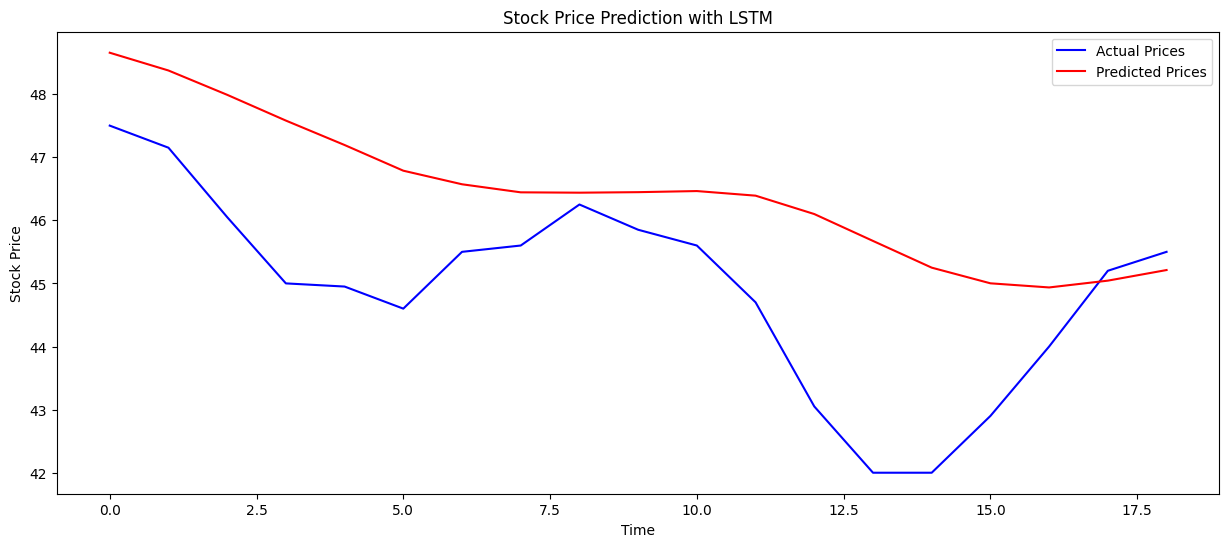

In [9]:
# Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()